# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 21.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 26.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 26.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 4.2 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp30 # use or create a database named demo
tweet_collection = db.lab11#use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [44]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [27]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [9]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [10]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5247764,-77.5633011,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [11]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Mon Nov 23 03:03:17 +0000 2020'
'Mon Nov 23 03:03:17 +0000 2020'
'Mon Nov 23 03:03:12 +0000 2020'
'Mon Nov 23 03:03:08 +0000 2020'
'Mon Nov 23 03:03:03 +0000 2020'
'Mon Nov 23 03:02:45 +0000 2020'
'Mon Nov 23 03:02:44 +0000 2020'
'Mon Nov 23 03:02:40 +0000 2020'
'Mon Nov 23 03:02:39 +0000 2020'
'Mon Nov 23 03:02:37 +0000 2020'
'Mon Nov 23 03:02:32 +0000 2020'
'Mon Nov 23 03:02:19 +0000 2020'
'Mon Nov 23 03:02:07 +0000 2020'
'Mon Nov 23 03:02:01 +0000 2020'
'Mon Nov 23 03:01:55 +0000 2020'
'Mon Nov 23 03:01:49 +0000 2020'
'Mon Nov 23 03:01:46 +0000 2020'
'Mon Nov 23 03:01:45 +0000 2020'
'Mon Nov 23 03:01:41 +0000 2020'
'Mon Nov 23 03:01:37 +0000 2020'
'Mon Nov 23 03:01:36 +0000 2020'
'Mon Nov 23 03:01:34 +0000 2020'
'Mon Nov 23 03:01:24 +0000 2020'
'Mon Nov 23 03:01:16 +0000 2020'
'Mon Nov 23 03:01:15 +0000 2020'
'Mon Nov 23 03:01:13 +0000 2020'
'Mon Nov 23 03:01:10 +0000 2020'
'Mon Nov 23 03:01:07 +0000 2020'
'Mon Nov 23 03:01:05 +0000 2020'
'Mon Nov 23 03:01:04 +0000 2020'
'Mon Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [12]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Mon Nov 23 02:52:44 +0000 2020'
'Mon Nov 23 02:52:28 +0000 2020'
'Mon Nov 23 02:52:26 +0000 2020'
'Mon Nov 23 02:52:13 +0000 2020'
'Mon Nov 23 02:52:09 +0000 2020'
'Mon Nov 23 02:52:07 +0000 2020'
'Mon Nov 23 02:52:06 +0000 2020'
'Mon Nov 23 02:52:05 +0000 2020'
'Mon Nov 23 02:51:49 +0000 2020'
'Mon Nov 23 02:51:49 +0000 2020'
'Mon Nov 23 02:51:37 +0000 2020'
'Mon Nov 23 02:51:33 +0000 2020'
'Mon Nov 23 02:51:23 +0000 2020'
'Mon Nov 23 02:51:10 +0000 2020'
'Mon Nov 23 02:51:04 +0000 2020'
'Mon Nov 23 02:50:59 +0000 2020'
'Mon Nov 23 02:50:58 +0000 2020'
'Mon Nov 23 02:50:57 +0000 2020'
'Mon Nov 23 02:50:50 +0000 2020'
'Mon Nov 23 02:50:48 +0000 2020'
'Mon Nov 23 02:50:47 +0000 2020'
'Mon Nov 23 02:50:44 +0000 2020'
'Mon Nov 23 02:50:43 +0000 2020'
'Mon Nov 23 02:50:32 +0000 2020'
'Mon Nov 23 02:50:30 +0000 2020'
'Mon Nov 23 02:50:29 +0000 2020'
'Mon Nov 23 02:50:25 +0000 2020'
'Mon Nov 23 02:50:21 +0000 2020'
'Mon Nov 23 02:50:20 +0000 2020'
'Mon Nov 23 02:50:16 +0000 2020'
'Mon Nov 2

'Mon Nov 23 02:35:39 +0000 2020'
'Mon Nov 23 02:35:33 +0000 2020'
'Mon Nov 23 02:35:32 +0000 2020'
'Mon Nov 23 02:35:28 +0000 2020'
'Mon Nov 23 02:35:28 +0000 2020'
'Mon Nov 23 02:35:26 +0000 2020'
'Mon Nov 23 02:35:25 +0000 2020'
'Mon Nov 23 02:35:23 +0000 2020'
'Mon Nov 23 02:35:16 +0000 2020'
'Mon Nov 23 02:35:14 +0000 2020'
'Mon Nov 23 02:35:14 +0000 2020'
'Mon Nov 23 02:35:14 +0000 2020'
'Mon Nov 23 02:35:12 +0000 2020'
'Mon Nov 23 02:35:11 +0000 2020'
'Mon Nov 23 02:35:10 +0000 2020'
'Mon Nov 23 02:35:09 +0000 2020'
'Mon Nov 23 02:35:05 +0000 2020'
'Mon Nov 23 02:35:04 +0000 2020'
'Mon Nov 23 02:35:02 +0000 2020'
'Mon Nov 23 02:35:00 +0000 2020'
'Mon Nov 23 02:34:59 +0000 2020'
'Mon Nov 23 02:34:58 +0000 2020'
'Mon Nov 23 02:34:54 +0000 2020'
'Mon Nov 23 02:34:52 +0000 2020'
'Mon Nov 23 02:34:51 +0000 2020'
'Mon Nov 23 02:34:50 +0000 2020'
'Mon Nov 23 02:34:49 +0000 2020'
'Mon Nov 23 02:34:44 +0000 2020'
'Mon Nov 23 02:34:43 +0000 2020'
'Mon Nov 23 02:34:42 +0000 2020'
'Mon Nov 2

'Sun Nov 22 20:54:30 +0000 2020'
'Sun Nov 22 20:54:13 +0000 2020'
'Sun Nov 22 20:54:10 +0000 2020'
'Sun Nov 22 20:54:08 +0000 2020'
'Sun Nov 22 20:53:58 +0000 2020'
'Sun Nov 22 20:53:52 +0000 2020'
'Sun Nov 22 20:53:52 +0000 2020'
'Sun Nov 22 20:53:47 +0000 2020'
'Sun Nov 22 20:53:38 +0000 2020'
'Sun Nov 22 20:53:27 +0000 2020'
'Sun Nov 22 20:53:24 +0000 2020'
'Sun Nov 22 20:53:16 +0000 2020'
'Sun Nov 22 20:52:46 +0000 2020'
'Sun Nov 22 20:52:23 +0000 2020'
'Sun Nov 22 20:51:20 +0000 2020'
'Sun Nov 22 20:50:35 +0000 2020'
'Sun Nov 22 20:50:26 +0000 2020'
'Sun Nov 22 20:50:20 +0000 2020'
'Sun Nov 22 20:50:13 +0000 2020'
'Sun Nov 22 20:50:10 +0000 2020'
'Sun Nov 22 20:49:20 +0000 2020'
'Sun Nov 22 20:49:00 +0000 2020'
'Sun Nov 22 20:48:51 +0000 2020'
'Sun Nov 22 20:48:33 +0000 2020'
'Sun Nov 22 20:48:19 +0000 2020'
'Sun Nov 22 20:48:07 +0000 2020'
'Sun Nov 22 20:48:00 +0000 2020'
'Sun Nov 22 20:47:49 +0000 2020'
'Sun Nov 22 20:47:45 +0000 2020'
'Sun Nov 22 20:47:06 +0000 2020'
'Sun Nov 2

'Sun Nov 22 19:53:47 +0000 2020'
'Sun Nov 22 19:53:10 +0000 2020'
'Sun Nov 22 19:53:07 +0000 2020'
'Sun Nov 22 19:52:37 +0000 2020'
'Sun Nov 22 19:52:36 +0000 2020'
'Sun Nov 22 19:52:25 +0000 2020'
'Sun Nov 22 19:52:19 +0000 2020'
'Sun Nov 22 19:52:14 +0000 2020'
'Sun Nov 22 19:52:09 +0000 2020'
'Sun Nov 22 19:52:08 +0000 2020'
'Sun Nov 22 19:52:00 +0000 2020'
'Sun Nov 22 19:51:53 +0000 2020'
'Sun Nov 22 19:51:34 +0000 2020'
'Sun Nov 22 19:51:32 +0000 2020'
'Sun Nov 22 19:51:17 +0000 2020'
'Sun Nov 22 19:51:15 +0000 2020'
'Sun Nov 22 19:51:14 +0000 2020'
'Sun Nov 22 19:51:13 +0000 2020'
'Sun Nov 22 19:51:11 +0000 2020'
'Sun Nov 22 19:51:04 +0000 2020'
'Sun Nov 22 19:50:51 +0000 2020'
'Sun Nov 22 19:50:33 +0000 2020'
'Sun Nov 22 19:50:13 +0000 2020'
'Sun Nov 22 19:50:10 +0000 2020'
'Sun Nov 22 19:50:05 +0000 2020'
'Sun Nov 22 19:49:45 +0000 2020'
'Sun Nov 22 19:49:36 +0000 2020'
'Sun Nov 22 19:49:26 +0000 2020'
'Sun Nov 22 19:49:25 +0000 2020'
'Sun Nov 22 19:49:20 +0000 2020'
'Sun Nov 2

'Sun Nov 22 19:12:19 +0000 2020'
'Sun Nov 22 19:12:10 +0000 2020'
'Sun Nov 22 19:12:08 +0000 2020'
'Sun Nov 22 19:12:02 +0000 2020'
'Sun Nov 22 19:12:01 +0000 2020'
'Sun Nov 22 19:11:56 +0000 2020'
'Sun Nov 22 19:11:55 +0000 2020'
'Sun Nov 22 19:11:54 +0000 2020'
'Sun Nov 22 19:11:52 +0000 2020'
'Sun Nov 22 19:11:22 +0000 2020'
'Sun Nov 22 19:11:19 +0000 2020'
'Sun Nov 22 19:11:00 +0000 2020'
'Sun Nov 22 19:10:40 +0000 2020'
'Sun Nov 22 19:10:37 +0000 2020'
'Sun Nov 22 19:10:35 +0000 2020'
'Sun Nov 22 19:10:29 +0000 2020'
'Sun Nov 22 19:10:14 +0000 2020'
'Sun Nov 22 19:10:11 +0000 2020'
'Sun Nov 22 19:10:00 +0000 2020'
'Sun Nov 22 19:09:57 +0000 2020'
'Sun Nov 22 19:09:23 +0000 2020'
'Sun Nov 22 19:09:18 +0000 2020'
'Sun Nov 22 19:08:58 +0000 2020'
'Sun Nov 22 19:08:33 +0000 2020'
'Sun Nov 22 19:08:28 +0000 2020'
'Sun Nov 22 19:08:23 +0000 2020'
'Sun Nov 22 19:08:14 +0000 2020'
'Sun Nov 22 19:08:13 +0000 2020'
'Sun Nov 22 19:08:12 +0000 2020'
'Sun Nov 22 19:08:00 +0000 2020'
'Sun Nov 2

'Sun Nov 22 18:39:37 +0000 2020'
'Sun Nov 22 18:39:37 +0000 2020'
'Sun Nov 22 18:39:35 +0000 2020'
'Sun Nov 22 18:39:29 +0000 2020'
'Sun Nov 22 18:39:26 +0000 2020'
'Sun Nov 22 18:39:12 +0000 2020'
'Sun Nov 22 18:39:06 +0000 2020'
'Sun Nov 22 18:39:01 +0000 2020'
'Sun Nov 22 18:38:38 +0000 2020'
'Sun Nov 22 18:38:32 +0000 2020'
'Sun Nov 22 18:38:30 +0000 2020'
'Sun Nov 22 18:38:30 +0000 2020'
'Sun Nov 22 18:38:28 +0000 2020'
'Sun Nov 22 18:38:26 +0000 2020'
'Sun Nov 22 18:38:22 +0000 2020'
'Sun Nov 22 18:38:01 +0000 2020'
'Sun Nov 22 18:37:45 +0000 2020'
'Sun Nov 22 18:37:45 +0000 2020'
'Sun Nov 22 18:37:33 +0000 2020'
'Sun Nov 22 18:37:32 +0000 2020'
'Sun Nov 22 18:37:31 +0000 2020'
'Sun Nov 22 18:37:26 +0000 2020'
'Sun Nov 22 18:37:20 +0000 2020'
'Sun Nov 22 18:37:18 +0000 2020'
'Sun Nov 22 18:37:06 +0000 2020'
'Sun Nov 22 18:36:41 +0000 2020'
'Sun Nov 22 18:36:10 +0000 2020'
'Sun Nov 22 18:36:04 +0000 2020'
'Sun Nov 22 18:35:54 +0000 2020'
'Sun Nov 22 18:35:41 +0000 2020'
'Sun Nov 2

'Sun Nov 22 17:57:46 +0000 2020'
'Sun Nov 22 17:57:11 +0000 2020'
'Sun Nov 22 17:57:09 +0000 2020'
'Sun Nov 22 17:57:06 +0000 2020'
'Sun Nov 22 17:57:04 +0000 2020'
'Sun Nov 22 17:56:59 +0000 2020'
'Sun Nov 22 17:56:58 +0000 2020'
'Sun Nov 22 17:56:39 +0000 2020'
'Sun Nov 22 17:56:36 +0000 2020'
'Sun Nov 22 17:56:34 +0000 2020'
'Sun Nov 22 17:56:29 +0000 2020'
'Sun Nov 22 17:56:27 +0000 2020'
'Sun Nov 22 17:56:21 +0000 2020'
'Sun Nov 22 17:56:20 +0000 2020'
'Sun Nov 22 17:56:15 +0000 2020'
'Sun Nov 22 17:56:00 +0000 2020'
'Sun Nov 22 17:55:54 +0000 2020'
'Sun Nov 22 17:55:48 +0000 2020'
'Sun Nov 22 17:55:36 +0000 2020'
'Sun Nov 22 17:55:10 +0000 2020'
'Sun Nov 22 17:54:33 +0000 2020'
'Sun Nov 22 17:54:29 +0000 2020'
'Sun Nov 22 17:54:17 +0000 2020'
'Sun Nov 22 17:54:14 +0000 2020'
'Sun Nov 22 17:54:09 +0000 2020'
'Sun Nov 22 17:54:08 +0000 2020'
'Sun Nov 22 17:54:07 +0000 2020'
'Sun Nov 22 17:54:00 +0000 2020'
'Sun Nov 22 17:53:56 +0000 2020'
'Sun Nov 22 17:53:40 +0000 2020'
'Sun Nov 2

'Sun Nov 22 17:28:33 +0000 2020'
'Sun Nov 22 17:28:32 +0000 2020'
'Sun Nov 22 17:28:06 +0000 2020'
'Sun Nov 22 17:28:03 +0000 2020'
'Sun Nov 22 17:27:55 +0000 2020'
'Sun Nov 22 17:27:53 +0000 2020'
'Sun Nov 22 17:27:45 +0000 2020'
'Sun Nov 22 17:27:42 +0000 2020'
'Sun Nov 22 17:27:32 +0000 2020'
'Sun Nov 22 17:27:19 +0000 2020'
'Sun Nov 22 17:27:18 +0000 2020'
'Sun Nov 22 17:27:15 +0000 2020'
'Sun Nov 22 17:27:00 +0000 2020'
'Sun Nov 22 17:26:46 +0000 2020'
'Sun Nov 22 17:26:34 +0000 2020'
'Sun Nov 22 17:26:30 +0000 2020'
'Sun Nov 22 17:26:30 +0000 2020'
'Sun Nov 22 17:26:30 +0000 2020'
'Sun Nov 22 17:26:27 +0000 2020'
'Sun Nov 22 17:26:25 +0000 2020'
'Sun Nov 22 17:26:24 +0000 2020'
'Sun Nov 22 17:26:12 +0000 2020'
'Sun Nov 22 17:26:10 +0000 2020'
'Sun Nov 22 17:26:08 +0000 2020'
'Sun Nov 22 17:26:08 +0000 2020'
'Sun Nov 22 17:26:07 +0000 2020'
'Sun Nov 22 17:25:59 +0000 2020'
'Sun Nov 22 17:25:50 +0000 2020'
'Sun Nov 22 17:25:43 +0000 2020'
'Sun Nov 22 17:25:23 +0000 2020'
'Sun Nov 2

'Sun Nov 22 17:07:10 +0000 2020'
'Sun Nov 22 17:07:08 +0000 2020'
'Sun Nov 22 17:07:07 +0000 2020'
'Sun Nov 22 17:07:06 +0000 2020'
'Sun Nov 22 17:06:58 +0000 2020'
'Sun Nov 22 17:06:53 +0000 2020'
'Sun Nov 22 17:06:50 +0000 2020'
'Sun Nov 22 17:06:46 +0000 2020'
'Sun Nov 22 17:06:13 +0000 2020'
'Sun Nov 22 17:06:12 +0000 2020'
'Sun Nov 22 17:06:11 +0000 2020'
'Sun Nov 22 17:06:11 +0000 2020'
'Sun Nov 22 17:06:09 +0000 2020'
'Sun Nov 22 17:06:09 +0000 2020'
'Sun Nov 22 17:06:07 +0000 2020'
'Sun Nov 22 17:05:56 +0000 2020'
'Sun Nov 22 17:05:53 +0000 2020'
'Sun Nov 22 17:05:47 +0000 2020'
'Sun Nov 22 17:05:42 +0000 2020'
'Sun Nov 22 17:05:41 +0000 2020'
'Sun Nov 22 17:05:38 +0000 2020'
'Sun Nov 22 17:05:32 +0000 2020'
'Sun Nov 22 17:05:28 +0000 2020'
'Sun Nov 22 17:05:21 +0000 2020'
'Sun Nov 22 17:05:13 +0000 2020'
'Sun Nov 22 17:05:12 +0000 2020'
'Sun Nov 22 17:05:08 +0000 2020'
'Sun Nov 22 17:05:07 +0000 2020'
'Sun Nov 22 17:05:07 +0000 2020'
'Sun Nov 22 17:05:02 +0000 2020'
'Sun Nov 2

'Sun Nov 22 16:30:45 +0000 2020'
'Sun Nov 22 16:30:42 +0000 2020'
'Sun Nov 22 16:30:34 +0000 2020'
'Sun Nov 22 16:30:28 +0000 2020'
'Sun Nov 22 16:30:25 +0000 2020'
'Sun Nov 22 16:30:23 +0000 2020'
'Sun Nov 22 16:30:23 +0000 2020'
'Sun Nov 22 16:30:19 +0000 2020'
'Sun Nov 22 16:30:08 +0000 2020'
'Sun Nov 22 16:30:01 +0000 2020'
'Sun Nov 22 16:29:59 +0000 2020'
'Sun Nov 22 16:29:57 +0000 2020'
'Sun Nov 22 16:29:42 +0000 2020'
'Sun Nov 22 16:29:42 +0000 2020'
'Sun Nov 22 16:29:30 +0000 2020'
'Sun Nov 22 16:29:25 +0000 2020'
'Sun Nov 22 16:29:17 +0000 2020'
'Sun Nov 22 16:29:05 +0000 2020'
'Sun Nov 22 16:28:24 +0000 2020'
'Sun Nov 22 16:28:09 +0000 2020'
'Sun Nov 22 16:28:05 +0000 2020'
'Sun Nov 22 16:28:04 +0000 2020'
'Sun Nov 22 16:28:00 +0000 2020'
'Sun Nov 22 16:27:57 +0000 2020'
'Sun Nov 22 16:27:47 +0000 2020'
'Sun Nov 22 16:27:45 +0000 2020'
'Sun Nov 22 16:27:08 +0000 2020'
'Sun Nov 22 16:27:03 +0000 2020'
'Sun Nov 22 16:26:57 +0000 2020'
'Sun Nov 22 16:26:38 +0000 2020'
'Sun Nov 2

'Sun Nov 22 15:45:05 +0000 2020'
'Sun Nov 22 15:45:03 +0000 2020'
'Sun Nov 22 15:45:01 +0000 2020'
'Sun Nov 22 15:44:55 +0000 2020'
'Sun Nov 22 15:44:32 +0000 2020'
'Sun Nov 22 15:44:26 +0000 2020'
'Sun Nov 22 15:44:16 +0000 2020'
'Sun Nov 22 15:43:47 +0000 2020'
'Sun Nov 22 15:43:46 +0000 2020'
'Sun Nov 22 15:43:39 +0000 2020'
'Sun Nov 22 15:43:30 +0000 2020'
'Sun Nov 22 15:42:58 +0000 2020'
'Sun Nov 22 15:42:56 +0000 2020'
'Sun Nov 22 15:42:54 +0000 2020'
'Sun Nov 22 15:42:50 +0000 2020'
'Sun Nov 22 15:42:43 +0000 2020'
'Sun Nov 22 15:42:40 +0000 2020'
'Sun Nov 22 15:42:24 +0000 2020'
'Sun Nov 22 15:42:20 +0000 2020'
'Sun Nov 22 15:42:14 +0000 2020'
'Sun Nov 22 15:42:13 +0000 2020'
'Sun Nov 22 15:41:55 +0000 2020'
'Sun Nov 22 15:41:33 +0000 2020'
'Sun Nov 22 15:41:32 +0000 2020'
'Sun Nov 22 15:41:29 +0000 2020'
'Sun Nov 22 15:41:17 +0000 2020'
'Sun Nov 22 15:41:13 +0000 2020'
'Sun Nov 22 15:41:07 +0000 2020'
'Sun Nov 22 15:41:04 +0000 2020'
'Sun Nov 22 15:41:03 +0000 2020'
'Sun Nov 2

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [13]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

5464
4702


Create a text index and print the Tweets containing specific keywords. 

In [14]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [15]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [16]:
#tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

In [17]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Sarah Anne Daigle
text: RT @nowdx1: We are seeking volunteers from Northwest #Arkansas for our #COVID19 saliva test study. If you have tested positive for #COVID19…
----
name: Mary Jane
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Wendy Nilsson
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: News 19 WLTX
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: charlie
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Vicky Allen
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be wid

Use pandas to display tweets

In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,lang,timestamp_ms,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,display_text_range,possibly_sensitive,extended_tweet,metadata
0,5fbb13162be99123f715e144,Mon Nov 23 01:40:33 +0000 2020,1330687651867889664,1330687651867889664,RT @redpillcivilwar: Clear election fraud. Ove...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,...,en,1606095633843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5fbb13212be99123f715e265,Mon Nov 23 01:40:44 +0000 2020,1330687696780595201,1330687696780595201,RT @DisclosureBP: Smartmatic's director admitt...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,...,en,1606095644551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5fbb132f2be99123f715e418,Mon Nov 23 01:40:58 +0000 2020,1330687756427792385,1330687756427792385,RT @Usatorz1: Why would Chicago’s Election Boa...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,en,1606095658772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5fbb13262be99123f715e309,Mon Nov 23 01:40:49 +0000 2020,1330687718427295744,1330687718427295744,RT @Usatorz1: Why would Chicago’s Election Boa...,"<a href=""http://twitter.com/#!/download/ipad"" ...",False,NaN,None,NaN,...,en,1606095649712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5fbb13182be99123f715e17f,Mon Nov 23 01:40:35 +0000 2020,1330687659799351304,1330687659799351304,RT @Usatorz1: Why would Chicago’s Election Boa...,"<a href=""http://twitter.com/#!/download/ipad"" ...",False,NaN,None,NaN,...,en,1606095635734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5fbb13292be99123f715e340,Mon Nov 23 01:40:51 +0000 2020,1330687727793278979,1330687727793278979,Vote for Warnock! #GA,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,en,1606095651945,1.330574e+18,1330574013056372737,{'created_at': 'Sun Nov 22 18:09:00 +0000 2020...,"{'url': 'https://t.co/DRfAii61Pm', 'expanded':...",NaN,NaN,NaN,NaN
6,5fbb132e2be99123f715e3e5,Mon Nov 23 01:40:57 +0000 2020,1330687749578502144,1330687749578502144,RT @Patty_Kag: Who won the election? Please vo...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1606095657139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5fbb13182be99123f715e171,Mon Nov 23 01:40:35 +0000 2020,1330687658213904384,1330687658213904384,@bluedawg7 @SenSchumer With all the Election F...,"<a href=""http://twitter.com/download/android"" ...",False,1.330687e+18,1330686843013263361,1.115232e+18,...,en,1606095635356,NaN,NaN,NaN,NaN,"[23, 96]",NaN,NaN,NaN
8,5fbb13312be99123f715e450,Mon Nov 23 01:41:00 +0000 2020,1330687764451520513,1330687764451520513,RT @marklutchman: I believe more than 80 milli...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,en,1606095660685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5fbb13192be99123f715e18b,Mon Nov 23 01:40:36 +0000 2020,1330687661355409409,1330687661355409409,Looking forward to the election integrity figh...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,...,en,1606095636105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


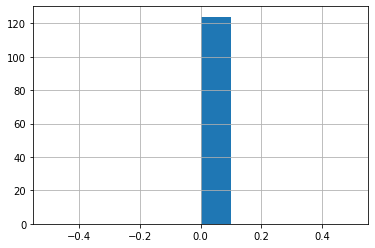

In [19]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count